In [1]:
!pip install -r requirements.txt
!pip install torchmetrics

In [17]:
import math
import os
import pickle
import time

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


from torch import device
from torch.utils.data import DataLoader, Subset
from torchmetrics.classification import MulticlassAccuracy
from tqdm import tqdm
from torchvision import datasets, utils
import torchvision.transforms as transforms

from efficient_kan.kan import KAN


#per analisi finale
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [18]:
dataset = [datasets.MNIST][0]
dataset_name = dataset.__name__.lower()
input_size = 28 * 28

transforms.Compose è una funzione di PyTorch utilizzata per applicare una serie di trasformazioni alle immagini. Usare transforms.ToTensor() all'interno di Compose implica le seguente cose:

- **transforms.Compose**: È usato per combinare più trasformazioni in sequenza. Le trasformazioni vengono applicate nell'ordine in cui sono definite.

- **transforms.ToTensor()**: Converte un'immagine PIL o un array NumPy in un tensore PyTorch. Inoltre, normalizza i valori dei pixel dall'intervallo [0, 255] a [0, 1].

In sintesi,  **trasforma un'immagine in un tensore**, rendendola pronta per l'input a una rete neurale.

In [19]:
transform = transforms.Compose([transforms.ToTensor(),])

# Train set. Here we sort the MNIST by digits and disable data shuffling

train_dataset = dataset(root='./data', train=True, download=True, transform=transform)
sorted_indices = sorted(range(len(train_dataset) // 1), key=lambda idx: train_dataset.targets[idx])
train_subset = Subset(train_dataset, sorted_indices)
train_loader = DataLoader(train_subset, batch_size=64, shuffle=False)



Questo codice suddivide il dataset in 5 gruppi basati sui target e crea un DataLoader per ciascuno

In [20]:
# MultiTask training sets
train_loader_tasks = []

indices = []
for k in range(5):
    indices.append(list(filter(lambda idx: train_dataset.targets[idx] in range(k * 2, k * 2 + 2), range(len(train_dataset)))))
    train_loader_tasks.append(DataLoader(Subset(train_dataset, indices[-1]), batch_size=64, shuffle=True))

# Test set
test_dataset = dataset(root='./data', train=False, download=True, transform=transform)
test_subset = Subset(test_dataset, range(len(test_dataset) // 1))
test_loader = DataLoader(test_subset, batch_size=64, shuffle=False)

#**Sorted MNIST training set (INTRA training set sorting)**

Qui i dati sono dati sequenzialmente, non dati mischiati!!

In [21]:
class EpochStat:
    @staticmethod
    def loadModelStats(name, dir=f'results/{dataset_name}/intra/', subdir='') -> list['EpochStat']:
        return sorted([pickle.load(open(f'{dir}{subdir}{file}', 'rb')) for file in
                       filter(lambda e: name == '_'.join(e.split('_')[:-1]), os.listdir(f'{dir}{subdir}'))],
                      key=lambda e: e.epoch)

    def __init__(self, name, epoch, train_loss=0, test_loss=0, labels=None, predictions=None, epoch_duration=0, lr=0,
                 train_losses=None, train_accuracies=None, task_id=None):
        self.name = name
        self.train_loss = train_loss
        self.test_loss = test_loss
        self.epoch = epoch
        self.predictions = predictions
        self.labels = labels
        self.epoch_duration = epoch_duration
        self.lr = lr
        self.train_losses = train_losses
        self.train_accuracies = train_accuracies
        self.task_id = task_id

    def save(self, dir=f'results/{dataset_name}/intra/'):
        os.makedirs(dir, exist_ok=True)
        pickle.dump(self, open(f'{dir}{self.name}_epoch{self.epoch}.pickle', 'wb'))

    def get_accuracy(self):
        accuracy = 0
        for label, prediction in zip(self.labels, self.predictions):
            if label == prediction:
                accuracy += 1
        return accuracy / len(self.labels)


def onEpochEnd(model, epoch, train_loss, epoch_duration, lr, task_id):
    test_loss, labels, predictions = test(model)
    stat = EpochStat(model.__class__.__name__, epoch, train_loss, test_loss, labels, predictions, epoch_duration,
                     lr, [], [], task_id)
    stat.save(  dir=f'results/{dataset_name}/intra/lr_{round(math.log10(lr))}/' if task_id is None else f'results/{dataset_name}/inter/lr_{round(math.log10(lr))}/')

# ARCHITECTURES DEFINITION
The various Fully Connected and Conv-based architectures employ the log_softmax() function on the logits. This indicates that a NLLLoss loss function should be used instead of Cross Entropy.

In [22]:
# MLP
class MLP(nn.Module):
    def __init__(self, checkpoint: str | None = None, output_size=10):
        super(MLP, self).__init__()
        self.layers = [input_size, 28 * 28, 256, output_size]

        self.fc1 = nn.Linear(self.layers[0], self.layers[1])
        self.fc2 = nn.Linear(self.layers[1], self.layers[2])
        self.fc3 = nn.Linear(self.layers[2], self.layers[3])

        if checkpoint:
            self.load_state_dict(torch.load(checkpoint))
            self.eval()

    def forward(self, x):
        x = x.view(-1, self.layers[0])
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x

In [23]:
class Efficient_KAN(nn.Module):
    def __init__(self, device=device, checkpoint: str | None = None, output_size=10):
        super(Efficient_KAN, self).__init__()
        self.layers = [input_size, 8, output_size]
        self.model = KAN(self.layers).to(device)
        if checkpoint:
            self.load_state_dict(torch.load(checkpoint))
            self.eval()

    def forward(self, x):
        x = x.view(-1, self.layers[0])
        x = self.model(x)
        x = F.log_softmax(x, dim=1)
        return x

FUNZIONE DI TRAINING

In [24]:
def train(model, checkpoint, optimizer, start_epoch=0, epochs=5, on_epoch_end=None, lr=0, loader=None,
          task_id=None):
    if loader is None:
        loader = train_loader
    criterion = nn.NLLLoss()
    # scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.996)
    for epoch in range(start_epoch, epochs + start_epoch):
        model.train()
        epoch_start = time.time_ns()
        with tqdm(loader) as pbar:
            for images, labels in pbar:
                labels = (labels % 2 if task_id is not None else labels).to(device)
                images = images.to(device)
                optimizer.zero_grad()
                output = model(images)
                loss = criterion(output, labels)
                loss.backward()
                optimizer.step(closure=lambda: loss)
                accuracy = (output.argmax(dim=1) == labels).float().mean()
                pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), lr=optimizer.param_groups[0]['lr'])
                # scheduler.step()
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}')
        epoch_duration = (time.time_ns() - epoch_start) // 1000000
        if on_epoch_end is not None:
            on_epoch_end(model, epoch, loss.item(), epoch_duration, lr, task_id)
        # torch.save(model.state_dict(), f'{checkpoint}_ep{epoch + 1}.pth')

FUNZIONE DI TEST

In [25]:
def test(model):
    model.eval()
    criterion = nn.NLLLoss()
    predictions = []
    ground_truths = []
    val_accuracy = 0
    loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = (labels % 2 if model.layers[-1] == 2 else labels).to(device)
            output = model(images)
            loss = criterion(output, labels)
            predictions.extend(output.argmax(dim=1).to('cpu').numpy())
            ground_truths.extend(labels.to('cpu').numpy())
            val_accuracy += (output.argmax(dim=1) == labels).float().mean().item()
    val_accuracy /= len(test_loader)
    print(f"Accuracy: {val_accuracy}")
    return loss.item(), ground_truths, predictions

In [26]:
for epochs, lr in zip([10], [1e-5]):
    models = [MLP(output_size=2), Efficient_KAN(output_size=2)]
    print(f'Using lr={lr} ------------------------------------')
    for model in [x.to(device) for x in models[:2]]:
        print(f'Training model={model.__class__.__name__}')
        for i, task in enumerate(train_loader_tasks):
            print(f'Training on task {i}')
            train(model, f'results/{dataset_name}/inter/{model.__class__.__name__}', epochs=epochs,
                  start_epoch=i * epochs, optimizer=optim.Adam(model.parameters(), lr=lr), on_epoch_end=onEpochEnd,
                  lr=lr, loader=task, task_id=i)

Using lr=1e-05 ------------------------------------
Training model=MLP
Training on task 0


100%|██████████| 198/198 [00:14<00:00, 13.85it/s, accuracy=1, loss=0.276, lr=1e-5]


Epoch 1, Loss: 0.275621622800827
Accuracy: 0.6023089171974523


100%|██████████| 198/198 [00:09<00:00, 19.81it/s, accuracy=1, loss=0.0679, lr=1e-5]


Epoch 2, Loss: 0.06788112968206406
Accuracy: 0.6025079617834395


100%|██████████| 198/198 [00:06<00:00, 30.28it/s, accuracy=1, loss=0.0152, lr=1e-5]


Epoch 3, Loss: 0.015153372660279274
Accuracy: 0.6017117834394905


100%|██████████| 198/198 [00:05<00:00, 35.69it/s, accuracy=1, loss=0.0115, lr=1e-5]


Epoch 4, Loss: 0.011501582339406013
Accuracy: 0.6018113057324841


100%|██████████| 198/198 [00:06<00:00, 32.69it/s, accuracy=1, loss=0.00803, lr=1e-5]


Epoch 5, Loss: 0.008033480495214462
Accuracy: 0.6006170382165605


100%|██████████| 198/198 [00:05<00:00, 34.65it/s, accuracy=1, loss=0.00291, lr=1e-5]


Epoch 6, Loss: 0.0029124035499989986
Accuracy: 0.6019108280254777


100%|██████████| 198/198 [00:05<00:00, 34.85it/s, accuracy=1, loss=0.00242, lr=1e-5]


Epoch 7, Loss: 0.002422596560791135
Accuracy: 0.6026074840764332


100%|██████████| 198/198 [00:06<00:00, 32.97it/s, accuracy=1, loss=0.00216, lr=1e-5]


Epoch 8, Loss: 0.0021558168809860945
Accuracy: 0.6014132165605095


100%|██████████| 198/198 [00:05<00:00, 36.58it/s, accuracy=1, loss=0.00139, lr=1e-5]


Epoch 9, Loss: 0.00138770358171314
Accuracy: 0.6025079617834395


100%|██████████| 198/198 [00:06<00:00, 31.11it/s, accuracy=1, loss=0.00433, lr=1e-5]


Epoch 10, Loss: 0.004333092365413904
Accuracy: 0.6052945859872612
Training on task 1


100%|██████████| 189/189 [00:05<00:00, 34.50it/s, accuracy=0.649, loss=0.752, lr=1e-5]


Epoch 11, Loss: 0.7522063255310059
Accuracy: 0.6703821656050956


100%|██████████| 189/189 [00:08<00:00, 21.67it/s, accuracy=0.789, loss=0.5, lr=1e-5]


Epoch 12, Loss: 0.500136137008667
Accuracy: 0.7291998407643312


100%|██████████| 189/189 [00:04<00:00, 37.91it/s, accuracy=0.877, loss=0.272, lr=1e-5]


Epoch 13, Loss: 0.27190741896629333
Accuracy: 0.7726910828025477


100%|██████████| 189/189 [00:06<00:00, 29.18it/s, accuracy=0.982, loss=0.131, lr=1e-5]


Epoch 14, Loss: 0.13146774470806122
Accuracy: 0.7891122611464968


100%|██████████| 189/189 [00:05<00:00, 37.23it/s, accuracy=0.947, loss=0.124, lr=1e-5]


Epoch 15, Loss: 0.12375613301992416
Accuracy: 0.792296974522293


100%|██████████| 189/189 [00:06<00:00, 28.96it/s, accuracy=0.982, loss=0.103, lr=1e-5]


Epoch 16, Loss: 0.10284671187400818
Accuracy: 0.7924960191082803


100%|██████████| 189/189 [00:05<00:00, 37.40it/s, accuracy=0.965, loss=0.144, lr=1e-5]


Epoch 17, Loss: 0.14370130002498627
Accuracy: 0.7908041401273885


100%|██████████| 189/189 [00:06<00:00, 29.49it/s, accuracy=0.982, loss=0.0487, lr=1e-5]


Epoch 18, Loss: 0.04870574548840523
Accuracy: 0.7860270700636943


100%|██████████| 189/189 [00:06<00:00, 28.19it/s, accuracy=0.947, loss=0.121, lr=1e-5]


Epoch 19, Loss: 0.12101778388023376
Accuracy: 0.783140923566879


100%|██████████| 189/189 [00:06<00:00, 28.79it/s, accuracy=0.982, loss=0.0684, lr=1e-5]


Epoch 20, Loss: 0.06840023398399353
Accuracy: 0.7825437898089171
Training on task 2


100%|██████████| 176/176 [00:04<00:00, 37.72it/s, accuracy=0.905, loss=0.286, lr=1e-5]


Epoch 21, Loss: 0.2864413261413574
Accuracy: 0.7538813694267515


100%|██████████| 176/176 [00:06<00:00, 28.25it/s, accuracy=0.952, loss=0.169, lr=1e-5]


Epoch 22, Loss: 0.1691003143787384
Accuracy: 0.695859872611465


100%|██████████| 176/176 [00:04<00:00, 37.07it/s, accuracy=0.984, loss=0.126, lr=1e-5]


Epoch 23, Loss: 0.12568672001361847
Accuracy: 0.6397292993630573


100%|██████████| 176/176 [00:05<00:00, 29.85it/s, accuracy=0.952, loss=0.153, lr=1e-5]


Epoch 24, Loss: 0.1525760143995285
Accuracy: 0.605593152866242


100%|██████████| 176/176 [00:04<00:00, 37.04it/s, accuracy=1, loss=0.0526, lr=1e-5]


Epoch 25, Loss: 0.05260593444108963
Accuracy: 0.5831011146496815


100%|██████████| 176/176 [00:05<00:00, 31.08it/s, accuracy=0.968, loss=0.0906, lr=1e-5]


Epoch 26, Loss: 0.09059485793113708
Accuracy: 0.5648885350318471


100%|██████████| 176/176 [00:05<00:00, 34.74it/s, accuracy=0.968, loss=0.083, lr=1e-5]


Epoch 27, Loss: 0.08299975097179413
Accuracy: 0.5582205414012739


100%|██████████| 176/176 [00:05<00:00, 31.85it/s, accuracy=0.984, loss=0.0623, lr=1e-5]


Epoch 28, Loss: 0.062297530472278595
Accuracy: 0.5492635350318471


100%|██████████| 176/176 [00:04<00:00, 37.14it/s, accuracy=0.984, loss=0.0408, lr=1e-5]


Epoch 29, Loss: 0.04081834852695465
Accuracy: 0.54578025477707


100%|██████████| 176/176 [00:05<00:00, 32.93it/s, accuracy=0.968, loss=0.0414, lr=1e-5]


Epoch 30, Loss: 0.04140283539891243
Accuracy: 0.5428941082802548
Training on task 3


100%|██████████| 191/191 [00:05<00:00, 35.67it/s, accuracy=0.957, loss=0.188, lr=1e-5]


Epoch 31, Loss: 0.18812771141529083
Accuracy: 0.6628184713375797


100%|██████████| 191/191 [00:05<00:00, 33.43it/s, accuracy=0.957, loss=0.127, lr=1e-5]


Epoch 32, Loss: 0.1269240826368332
Accuracy: 0.7055135350318471


100%|██████████| 191/191 [00:05<00:00, 37.63it/s, accuracy=0.87, loss=0.241, lr=1e-5]


Epoch 33, Loss: 0.24098291993141174
Accuracy: 0.73546974522293


100%|██████████| 191/191 [00:05<00:00, 32.49it/s, accuracy=0.957, loss=0.115, lr=1e-5]


Epoch 34, Loss: 0.11500117927789688
Accuracy: 0.7519904458598726


100%|██████████| 191/191 [00:05<00:00, 38.13it/s, accuracy=1, loss=0.00293, lr=1e-5]


Epoch 35, Loss: 0.0029259666334837675
Accuracy: 0.7644307324840764


100%|██████████| 191/191 [00:05<00:00, 32.79it/s, accuracy=1, loss=0.0127, lr=1e-5]


Epoch 36, Loss: 0.012703833170235157
Accuracy: 0.772890127388535


100%|██████████| 191/191 [00:05<00:00, 32.03it/s, accuracy=1, loss=0.00685, lr=1e-5]


Epoch 37, Loss: 0.006854943465441465
Accuracy: 0.7786624203821656


100%|██████████| 191/191 [00:06<00:00, 29.01it/s, accuracy=1, loss=0.00466, lr=1e-5]


Epoch 38, Loss: 0.004657375626266003
Accuracy: 0.7834394904458599


100%|██████████| 191/191 [00:05<00:00, 37.48it/s, accuracy=1, loss=0.00552, lr=1e-5]


Epoch 39, Loss: 0.00552322855219245
Accuracy: 0.7911027070063694


100%|██████████| 191/191 [00:06<00:00, 29.42it/s, accuracy=0.957, loss=0.0748, lr=1e-5]


Epoch 40, Loss: 0.07475545257329941
Accuracy: 0.7900079617834395
Training on task 4


100%|██████████| 185/185 [00:05<00:00, 36.79it/s, accuracy=0.833, loss=0.432, lr=1e-5]


Epoch 41, Loss: 0.43187007308006287
Accuracy: 0.76453025477707


100%|██████████| 185/185 [00:06<00:00, 29.29it/s, accuracy=0.917, loss=0.294, lr=1e-5]


Epoch 42, Loss: 0.2939811944961548
Accuracy: 0.7300955414012739


100%|██████████| 185/185 [00:04<00:00, 37.00it/s, accuracy=1, loss=0.0848, lr=1e-5]


Epoch 43, Loss: 0.0847729817032814
Accuracy: 0.7052149681528662


100%|██████████| 185/185 [00:06<00:00, 30.38it/s, accuracy=0.917, loss=0.285, lr=1e-5]


Epoch 44, Loss: 0.2853357493877411
Accuracy: 0.6827229299363057


100%|██████████| 185/185 [00:04<00:00, 37.18it/s, accuracy=1, loss=0.0571, lr=1e-5]


Epoch 45, Loss: 0.057080451399087906
Accuracy: 0.663515127388535


100%|██████████| 185/185 [00:06<00:00, 29.96it/s, accuracy=0.958, loss=0.119, lr=1e-5]


Epoch 46, Loss: 0.11900990456342697
Accuracy: 0.6509753184713376


100%|██████████| 185/185 [00:05<00:00, 36.32it/s, accuracy=1, loss=0.0177, lr=1e-5]


Epoch 47, Loss: 0.017749987542629242
Accuracy: 0.6427149681528662


100%|██████████| 185/185 [00:06<00:00, 30.29it/s, accuracy=1, loss=0.0434, lr=1e-5]


Epoch 48, Loss: 0.04340179264545441
Accuracy: 0.6353503184713376


100%|██████████| 185/185 [00:05<00:00, 36.58it/s, accuracy=0.958, loss=0.0816, lr=1e-5]


Epoch 49, Loss: 0.0815545916557312
Accuracy: 0.6298765923566879


100%|██████████| 185/185 [00:06<00:00, 29.72it/s, accuracy=0.958, loss=0.129, lr=1e-5]


Epoch 50, Loss: 0.1290399134159088
Accuracy: 0.6236066878980892
Training model=Efficient_KAN
Training on task 0


100%|██████████| 198/198 [00:06<00:00, 30.92it/s, accuracy=0.526, loss=0.693, lr=1e-5]


Epoch 1, Loss: 0.6931473016738892
Accuracy: 0.49263535031847133


100%|██████████| 198/198 [00:07<00:00, 26.69it/s, accuracy=0.491, loss=0.693, lr=1e-5]


Epoch 2, Loss: 0.6931473016738892
Accuracy: 0.49263535031847133


100%|██████████| 198/198 [00:07<00:00, 24.94it/s, accuracy=0.474, loss=0.693, lr=1e-5]


Epoch 3, Loss: 0.6931473016738892
Accuracy: 0.49263535031847133


100%|██████████| 198/198 [00:08<00:00, 24.73it/s, accuracy=0.439, loss=0.693, lr=1e-5]


Epoch 4, Loss: 0.6931473016738892
Accuracy: 0.49263535031847133


100%|██████████| 198/198 [00:06<00:00, 31.11it/s, accuracy=0.439, loss=0.693, lr=1e-5]


Epoch 5, Loss: 0.6931473016738892
Accuracy: 0.49263535031847133


100%|██████████| 198/198 [00:07<00:00, 27.75it/s, accuracy=0.526, loss=0.693, lr=1e-5]


Epoch 6, Loss: 0.6931473016738892
Accuracy: 0.49263535031847133


100%|██████████| 198/198 [00:08<00:00, 24.44it/s, accuracy=0.544, loss=0.693, lr=1e-5]


Epoch 7, Loss: 0.6931473016738892
Accuracy: 0.49263535031847133


100%|██████████| 198/198 [00:07<00:00, 26.48it/s, accuracy=0.386, loss=0.693, lr=1e-5]


Epoch 8, Loss: 0.6931473016738892
Accuracy: 0.49263535031847133


100%|██████████| 198/198 [00:06<00:00, 30.76it/s, accuracy=0.456, loss=0.693, lr=1e-5]


Epoch 9, Loss: 0.6931473016738892
Accuracy: 0.49263535031847133


100%|██████████| 198/198 [00:06<00:00, 30.46it/s, accuracy=0.421, loss=0.693, lr=1e-5]


Epoch 10, Loss: 0.6931473016738892
Accuracy: 0.49263535031847133
Training on task 1


100%|██████████| 189/189 [00:07<00:00, 24.55it/s, accuracy=0.579, loss=0.693, lr=1e-5]


Epoch 11, Loss: 0.6931473016738892
Accuracy: 0.49263535031847133


100%|██████████| 189/189 [00:07<00:00, 26.16it/s, accuracy=0.386, loss=0.693, lr=1e-5]


Epoch 12, Loss: 0.6931473016738892
Accuracy: 0.49263535031847133


100%|██████████| 189/189 [00:07<00:00, 26.55it/s, accuracy=0.456, loss=0.693, lr=1e-5]


Epoch 13, Loss: 0.6931473016738892
Accuracy: 0.49263535031847133


100%|██████████| 189/189 [00:06<00:00, 31.20it/s, accuracy=0.509, loss=0.693, lr=1e-5]


Epoch 14, Loss: 0.6931473016738892
Accuracy: 0.49263535031847133


100%|██████████| 189/189 [00:07<00:00, 26.02it/s, accuracy=0.456, loss=0.693, lr=1e-5]


Epoch 15, Loss: 0.6931473016738892
Accuracy: 0.49263535031847133


100%|██████████| 189/189 [00:07<00:00, 24.97it/s, accuracy=0.509, loss=0.693, lr=1e-5]


Epoch 16, Loss: 0.6931473016738892
Accuracy: 0.49263535031847133


100%|██████████| 189/189 [00:06<00:00, 28.29it/s, accuracy=0.544, loss=0.693, lr=1e-5]


Epoch 17, Loss: 0.6931473016738892
Accuracy: 0.49263535031847133


100%|██████████| 189/189 [00:06<00:00, 31.19it/s, accuracy=0.474, loss=0.693, lr=1e-5]


Epoch 18, Loss: 0.6931473016738892
Accuracy: 0.49263535031847133


100%|██████████| 189/189 [00:07<00:00, 25.94it/s, accuracy=0.474, loss=0.693, lr=1e-5]


Epoch 19, Loss: 0.6931473016738892
Accuracy: 0.49263535031847133


100%|██████████| 189/189 [00:07<00:00, 25.73it/s, accuracy=0.579, loss=0.693, lr=1e-5]


Epoch 20, Loss: 0.6931473016738892
Accuracy: 0.49263535031847133
Training on task 2


100%|██████████| 176/176 [00:05<00:00, 30.10it/s, accuracy=0.46, loss=0.693, lr=1e-5]


Epoch 21, Loss: 0.6931473016738892
Accuracy: 0.49263535031847133


100%|██████████| 176/176 [00:06<00:00, 29.13it/s, accuracy=0.508, loss=0.693, lr=1e-5]


Epoch 22, Loss: 0.6931473016738892
Accuracy: 0.49263535031847133


100%|██████████| 176/176 [00:07<00:00, 24.11it/s, accuracy=0.508, loss=0.693, lr=1e-5]


Epoch 23, Loss: 0.6931473016738892
Accuracy: 0.49263535031847133


100%|██████████| 176/176 [00:05<00:00, 30.65it/s, accuracy=0.429, loss=0.693, lr=1e-5]


Epoch 24, Loss: 0.6931473016738892
Accuracy: 0.49263535031847133


100%|██████████| 176/176 [00:05<00:00, 30.31it/s, accuracy=0.556, loss=0.693, lr=1e-5]


Epoch 25, Loss: 0.6931473016738892
Accuracy: 0.49263535031847133


100%|██████████| 176/176 [00:07<00:00, 24.42it/s, accuracy=0.508, loss=0.693, lr=1e-5]


Epoch 26, Loss: 0.6931473016738892
Accuracy: 0.49263535031847133


100%|██████████| 176/176 [00:06<00:00, 25.88it/s, accuracy=0.381, loss=0.693, lr=1e-5]


Epoch 27, Loss: 0.6931473016738892
Accuracy: 0.49263535031847133


100%|██████████| 176/176 [00:06<00:00, 26.54it/s, accuracy=0.524, loss=0.693, lr=1e-5]


Epoch 28, Loss: 0.6931473016738892
Accuracy: 0.49263535031847133


100%|██████████| 176/176 [00:05<00:00, 29.58it/s, accuracy=0.603, loss=0.693, lr=1e-5]


Epoch 29, Loss: 0.6931473016738892
Accuracy: 0.49263535031847133


100%|██████████| 176/176 [00:07<00:00, 24.17it/s, accuracy=0.571, loss=0.693, lr=1e-5]


Epoch 30, Loss: 0.6931473016738892
Accuracy: 0.49263535031847133
Training on task 3


100%|██████████| 191/191 [00:06<00:00, 28.66it/s, accuracy=0.478, loss=0.693, lr=1e-5]


Epoch 31, Loss: 0.6931472420692444
Accuracy: 0.49263535031847133


100%|██████████| 191/191 [00:06<00:00, 30.59it/s, accuracy=0.435, loss=0.693, lr=1e-5]


Epoch 32, Loss: 0.6931472420692444
Accuracy: 0.49263535031847133


100%|██████████| 191/191 [00:07<00:00, 27.04it/s, accuracy=0.522, loss=0.693, lr=1e-5]


Epoch 33, Loss: 0.6931472420692444
Accuracy: 0.49263535031847133


100%|██████████| 191/191 [00:07<00:00, 24.85it/s, accuracy=0.522, loss=0.693, lr=1e-5]


Epoch 34, Loss: 0.6931472420692444
Accuracy: 0.49263535031847133


100%|██████████| 191/191 [00:06<00:00, 29.26it/s, accuracy=0.478, loss=0.693, lr=1e-5]


Epoch 35, Loss: 0.6931472420692444
Accuracy: 0.49263535031847133


100%|██████████| 191/191 [00:06<00:00, 30.18it/s, accuracy=0.609, loss=0.693, lr=1e-5]


Epoch 36, Loss: 0.6931472420692444
Accuracy: 0.49263535031847133


100%|██████████| 191/191 [00:07<00:00, 26.52it/s, accuracy=0.609, loss=0.693, lr=1e-5]


Epoch 37, Loss: 0.6931472420692444
Accuracy: 0.49263535031847133


100%|██████████| 191/191 [00:07<00:00, 24.43it/s, accuracy=0.478, loss=0.693, lr=1e-5]


Epoch 38, Loss: 0.6931472420692444
Accuracy: 0.49263535031847133


100%|██████████| 191/191 [00:06<00:00, 30.21it/s, accuracy=0.261, loss=0.693, lr=1e-5]


Epoch 39, Loss: 0.6931472420692444
Accuracy: 0.49263535031847133


100%|██████████| 191/191 [00:06<00:00, 30.56it/s, accuracy=0.391, loss=0.693, lr=1e-5]


Epoch 40, Loss: 0.6931472420692444
Accuracy: 0.49263535031847133
Training on task 4


100%|██████████| 185/185 [00:08<00:00, 22.56it/s, accuracy=0.458, loss=0.693, lr=1e-5]


Epoch 41, Loss: 0.6931472420692444
Accuracy: 0.49263535031847133


100%|██████████| 185/185 [00:07<00:00, 26.41it/s, accuracy=0.625, loss=0.693, lr=1e-5]


Epoch 42, Loss: 0.6931472420692444
Accuracy: 0.49263535031847133


100%|██████████| 185/185 [00:06<00:00, 29.41it/s, accuracy=0.417, loss=0.693, lr=1e-5]


Epoch 43, Loss: 0.6931472420692444
Accuracy: 0.49263535031847133


100%|██████████| 185/185 [00:06<00:00, 27.16it/s, accuracy=0.458, loss=0.693, lr=1e-5]


Epoch 44, Loss: 0.6931472420692444
Accuracy: 0.49263535031847133


100%|██████████| 185/185 [00:07<00:00, 24.19it/s, accuracy=0.375, loss=0.693, lr=1e-5]


Epoch 45, Loss: 0.6931472420692444
Accuracy: 0.49263535031847133


100%|██████████| 185/185 [00:06<00:00, 27.84it/s, accuracy=0.417, loss=0.693, lr=1e-5]


Epoch 46, Loss: 0.6931472420692444
Accuracy: 0.49263535031847133


100%|██████████| 185/185 [00:06<00:00, 30.45it/s, accuracy=0.458, loss=0.693, lr=1e-5]


Epoch 47, Loss: 0.6931472420692444
Accuracy: 0.49263535031847133


100%|██████████| 185/185 [00:06<00:00, 26.69it/s, accuracy=0.5, loss=0.693, lr=1e-5]


Epoch 48, Loss: 0.6931472420692444
Accuracy: 0.49263535031847133


100%|██████████| 185/185 [00:07<00:00, 24.83it/s, accuracy=0.458, loss=0.693, lr=1e-5]


Epoch 49, Loss: 0.6931472420692444
Accuracy: 0.49263535031847133


100%|██████████| 185/185 [00:06<00:00, 30.35it/s, accuracy=0.417, loss=0.693, lr=1e-5]


Epoch 50, Loss: 0.6931472420692444
Accuracy: 0.49263535031847133


FUNZIONI PER I PLOT

TASK ID = 0


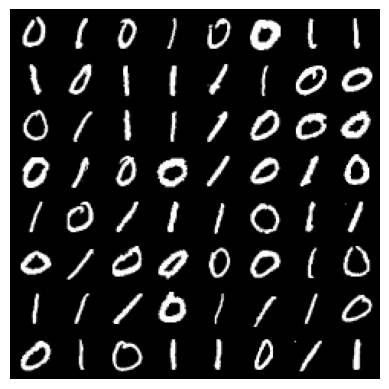

TASK ID = 1


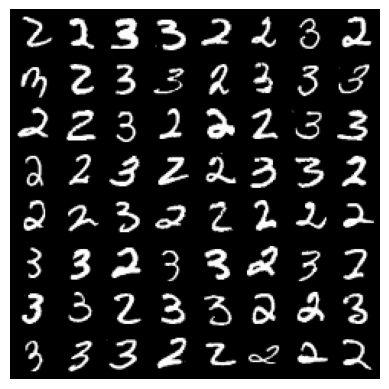

TASK ID = 2


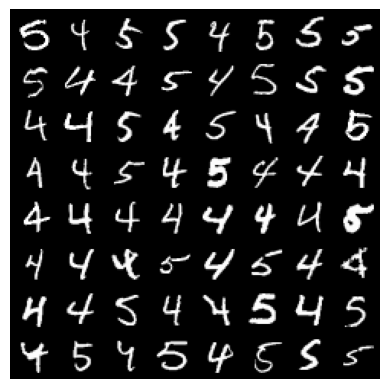

TASK ID = 3


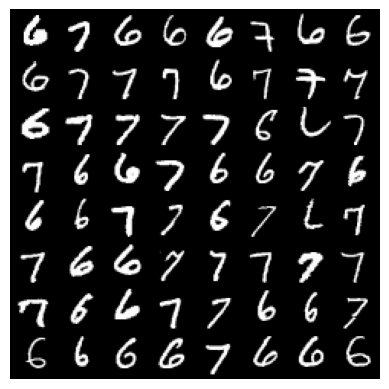

TASK ID = 4


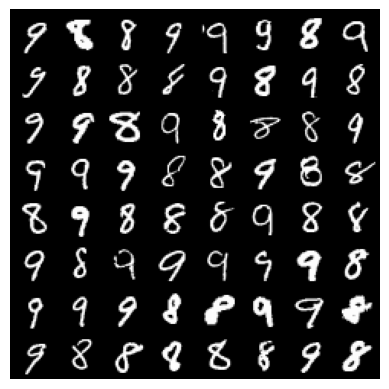

In [27]:
def imshow(img):
    # img = (img / 2 + 0.5).numpy()
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.axis('off')
    plt.show()


def show_images(class_index, num_images=16):
    dataiter = iter(train_loader_tasks[class_index])
    images, labels = next(dataiter)
    imshow(utils.make_grid(images))


for class_index in range(5):
    print(f"TASK ID = {class_index}")
    show_images(class_index)

** RESULTING PLOTS**


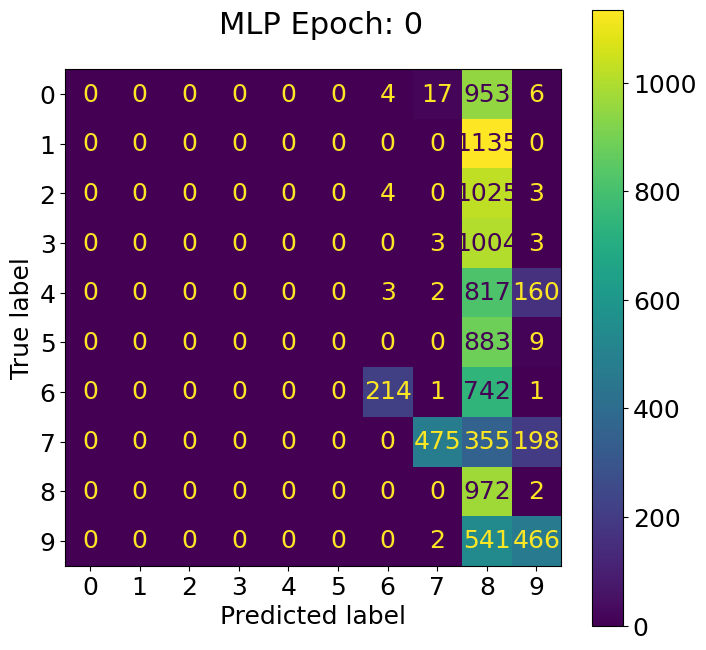

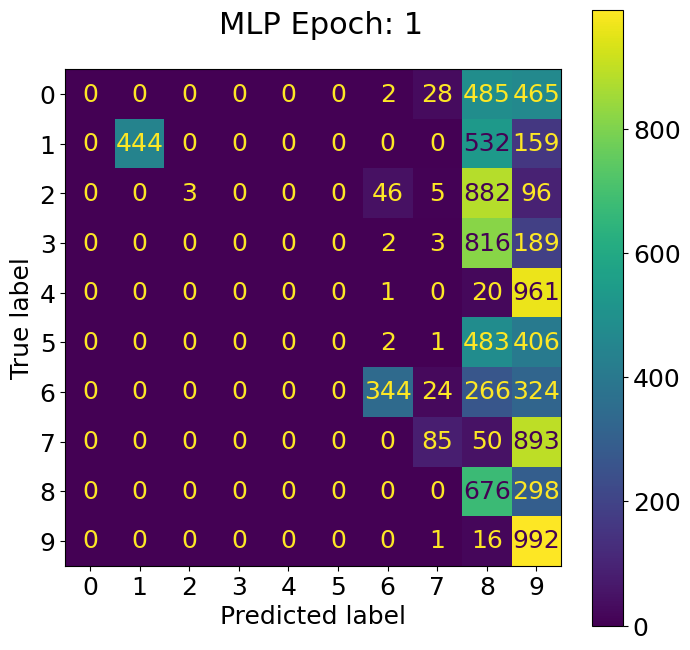

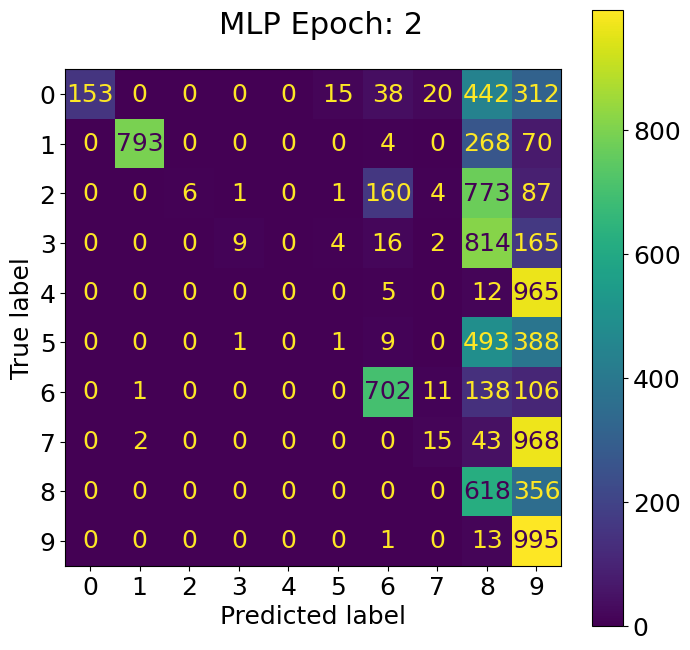

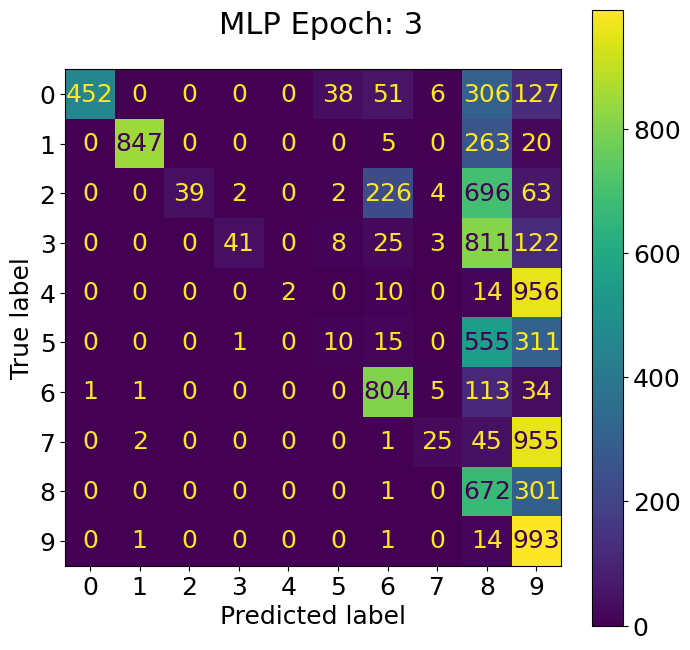

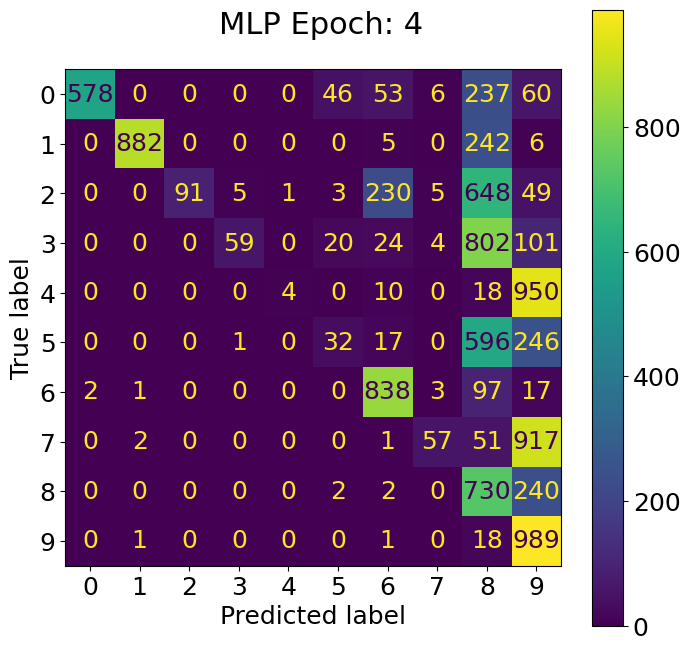

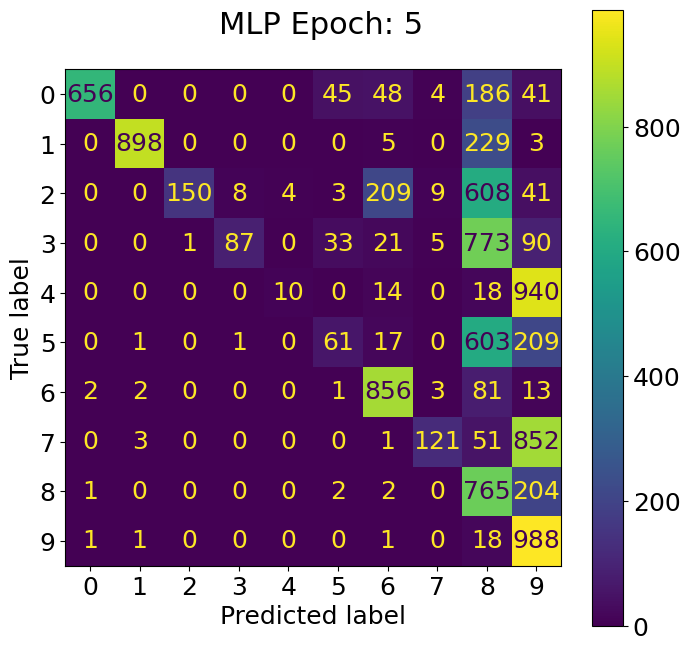

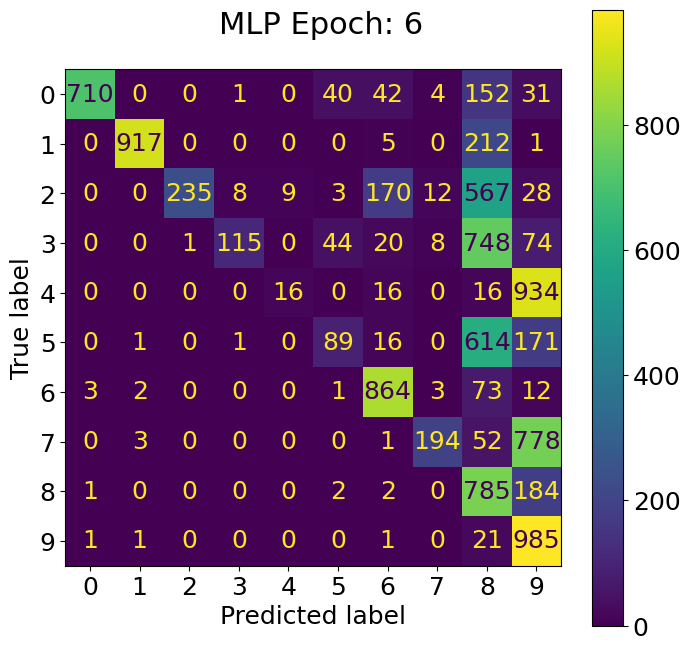

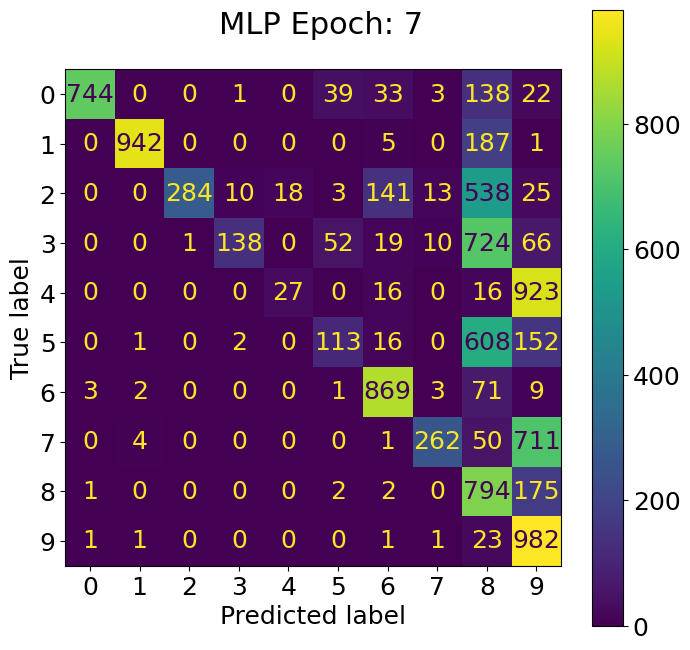

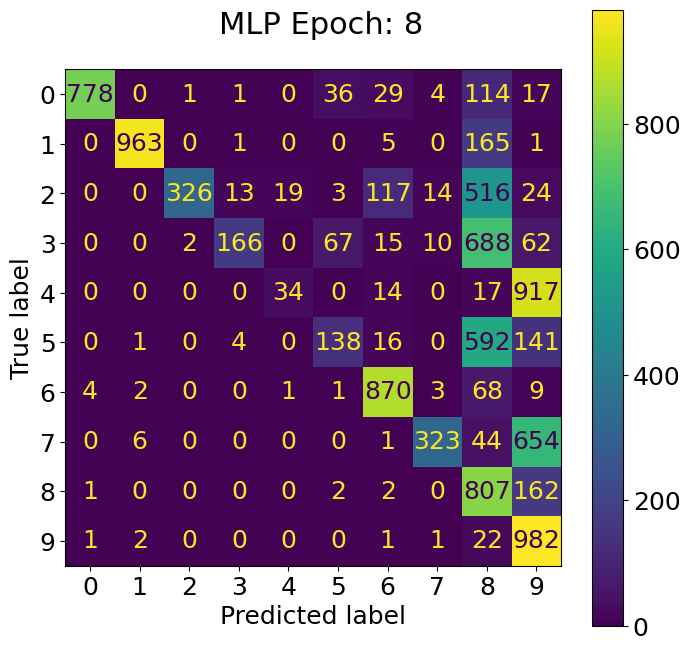

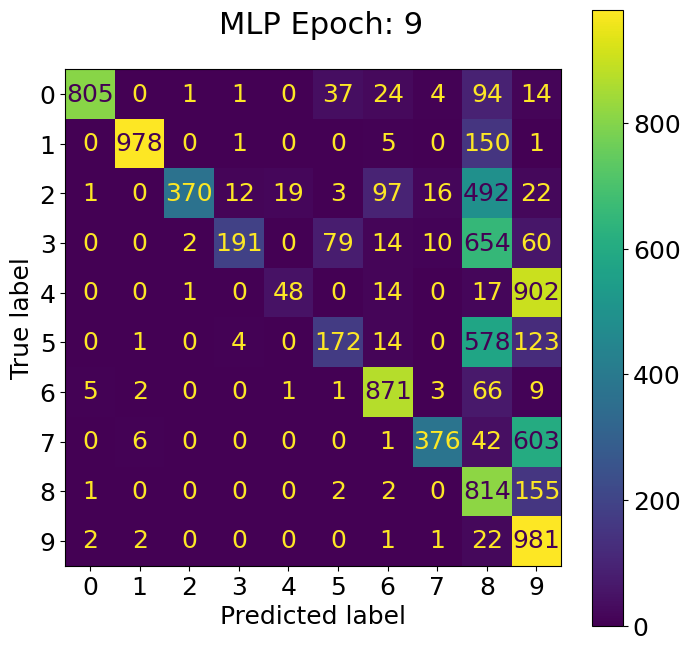

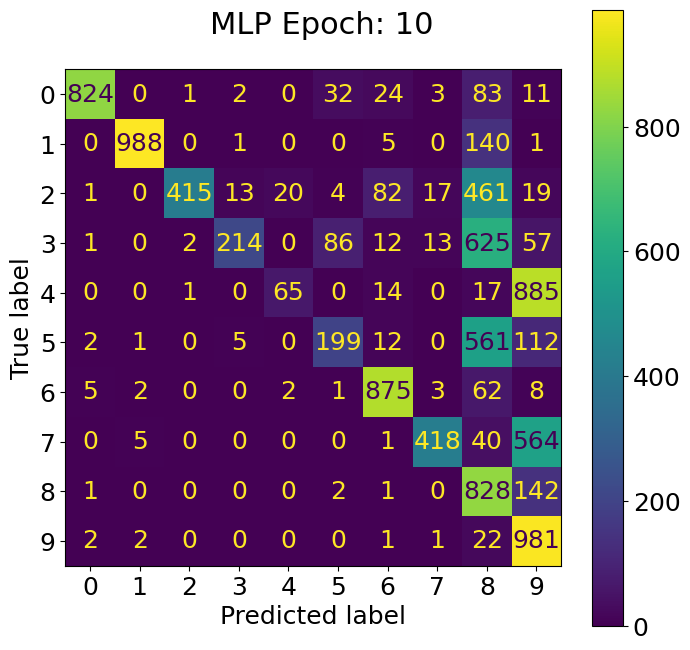

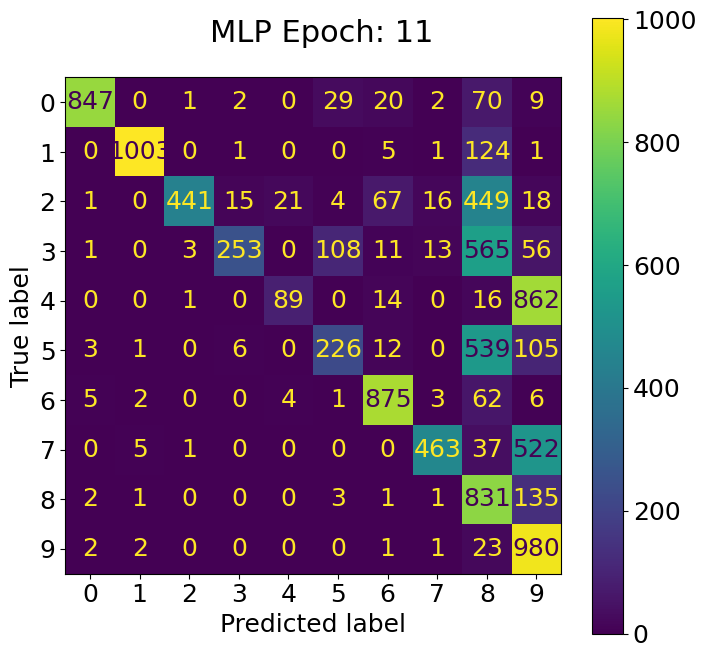

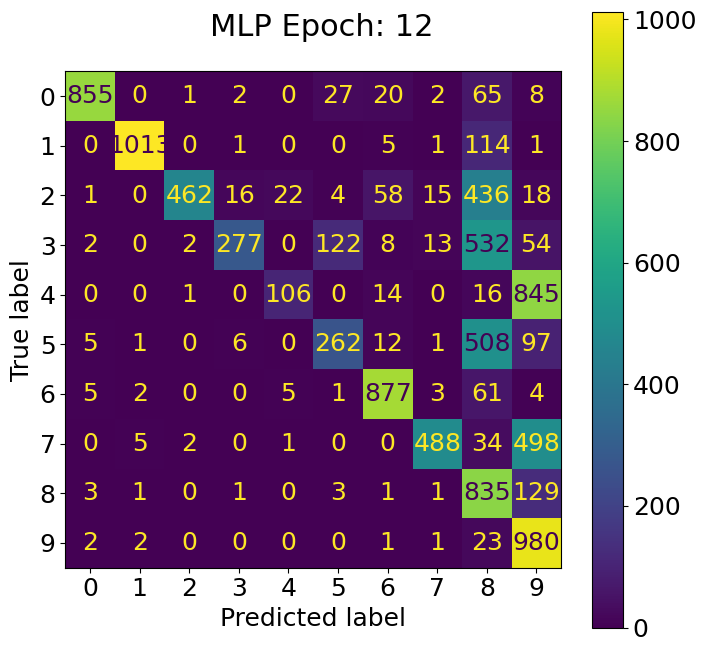

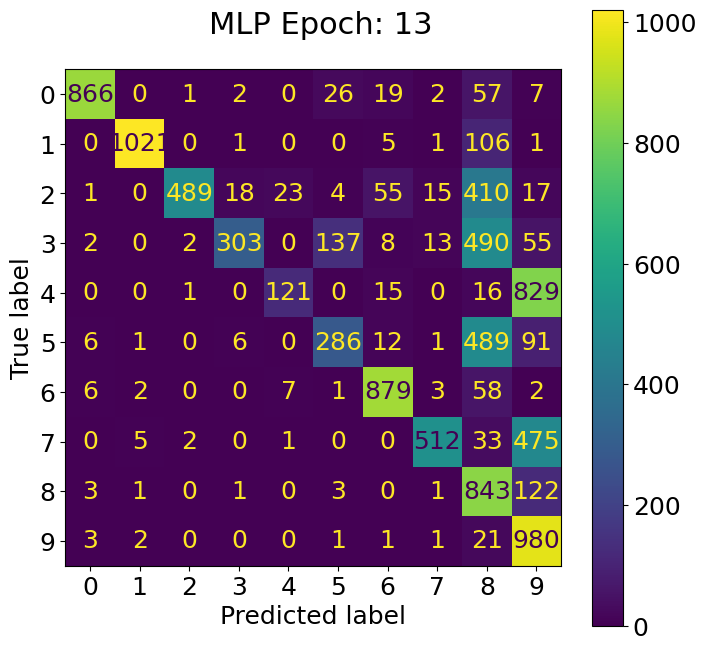

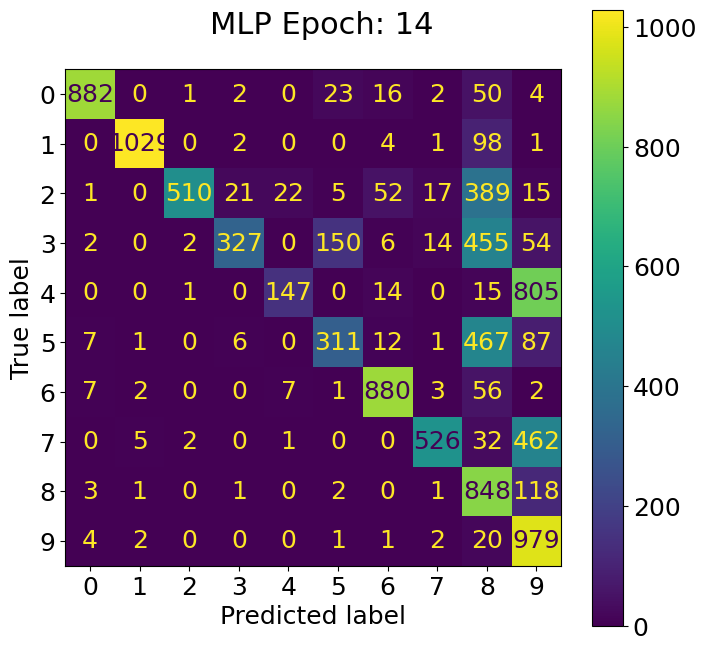

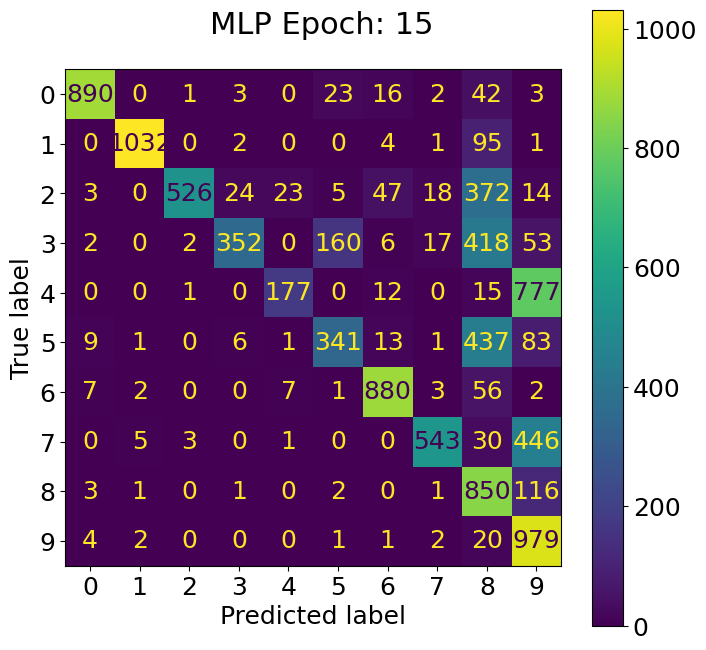

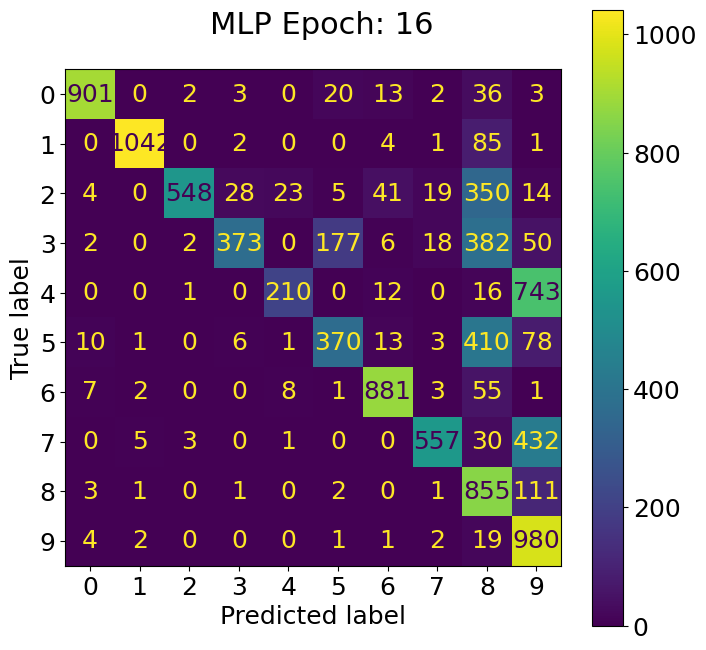

In [28]:
models = [MLP(), Efficient_KAN()]

plt.rc('font', size=18)
for lr in [1e-5]:
    for name in list(map(lambda e: e.__class__.__name__, models[:2])):
        stats = EpochStat.loadModelStats(name, dir=f'results/{dataset_name}/intra/',
                                         subdir=f'lr_{round(math.log10(lr))}/')
        for stat in stats[:]:
            cm = confusion_matrix(stat.labels, stat.predictions, labels=range(10))
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
            disp.plot()
            fig = disp.ax_.get_figure()
            fig.set_figwidth(8)
            fig.set_figheight(8)
            plt.figtext(0.445, 0.85, f"{name.replace('Efficient_KAN', 'KAN')} Epoch: {stat.epoch}", ha='center',
                        fontsize=22)
            fig.savefig(f'png/{dataset_name}/intra/lr_{round(math.log10(lr))}/{name} ep{stat.epoch}.png')